<a href="https://colab.research.google.com/github/PraveenAllam93/DataScience-BusinessCaseStudies/blob/main/RCA/Uber_RCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.simplefilter('ignore')

sns.set_style('whitegrid')

In [3]:
from google.colab import files
uploaded = files.upload()

Saving uber-data.csv to uber-data.csv


---
### Problem Statement :
---
* Uber has received some complaints from their customers facing problems related to ride cancellations by the driver and non-availability of cars for a specific route in the city.

* The uneven supply-demand gap for cabs from City to Airport and vice-versa is causing a bad effect on customer relationships as well as Uber is losing out on its revenue.

* The aim of analysis is to identify the root cause of the problem (i.e. cancellation and non-availability of cars) and recommend ways to tackle the situation.

---

In [4]:
#Loading the dataset

df = pd.read_csv('uber-data.csv')
df.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Request id         6745 non-null   int64  
 1   Pickup point       6745 non-null   object 
 2   Driver id          4095 non-null   float64
 3   Status             6745 non-null   object 
 4   Request timestamp  6745 non-null   object 
 5   Drop timestamp     2831 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 316.3+ KB


---
We can look there are some missing values in 'Driver id' and in 'Drop timestamp'


* missing values in 'Driver id' indicates that there is no driver assigned for the request (non availability of cars) 
* missing values in 'Drop  timestamp' indicates that there is driver assigned to the request but the trip did not complete (may be driver/user cancelled the ride)

---




In [6]:
print(f'Number of rows : {df.shape[0]}')
print(f'Number of colomns : {df.shape[1]}')

Number of rows : 6745
Number of colomns : 6


### Root Cause Analysis to identify the problem which is causing non-availability of cars in specific route, and problems related to cancellation.
---

* Cancellation rate : # of confirmed bookings /# of rider requests
* unavialability : # of requests where cab wasn't found 

In [7]:
df['Pickup point'].value_counts(sort = True, normalize = True, )

# There are two pickup points in the dataset, almost equally distributed.

City       0.519941
Airport    0.480059
Name: Pickup point, dtype: float64

In [8]:
df.Status.value_counts(sort = True, normalize = True)

# Cancelled are those which are cancelled by drivers/customers, No cars Available is a demand to supply issue.

Trip Completed       0.419718
No Cars Available    0.392884
Cancelled            0.187398
Name: Status, dtype: float64

---
### Handling Missing Values & Duplicated values
---

In [9]:
# Checking for null values

(df.isnull().sum() / len(df)) * 100

Request id            0.000000
Pickup point          0.000000
Driver id            39.288362
Status                0.000000
Request timestamp     0.000000
Drop timestamp       58.028169
dtype: float64

In [10]:
# changing NaN in Driver id as demand supply issuse and Drop timestamp as cancelled ride

df.loc[df['Driver id'].isnull(), 'Driver id'] = 'No drivers present'
df.loc[df['Drop timestamp'].isnull(), 'Drop timestamp'] = 'Ride not completed successfully'

In [11]:
(df.isnull().sum() / len(df)) * 100

Request id           0.0
Pickup point         0.0
Driver id            0.0
Status               0.0
Request timestamp    0.0
Drop timestamp       0.0
dtype: float64

In [12]:
print(f'Number of duplicated rows : {df.duplicated().sum()}')

Number of duplicated rows : 0


---
### Extarcting new features from the data
---

In [13]:
# Extracting hour from request timestamp

df['request hour'] = pd.to_datetime(df['Request timestamp']).dt.hour

In [14]:
# binning the request hour into Dawn, Morning, Noon, Evening, Night

df['times of day'] = df['request hour'].apply(lambda x : 'Dawn' if x <= 4 else 'Early Morning' if x <= 9 else 'Morning'
                                                                                               if x <= 12 else 'Noon'
                                                                                               if x <= 16 else 'Evening'
                                                                                               if x <= 21 else 'Night')

In [15]:
# if the trip is completed then making the cab is available or else not

df['cab availability'] = df['Status'].apply(lambda x : 'Available' if x == 'Trip Completed' else 'Not available')

In [16]:
df.sample(7)

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,request hour,times of day,cab availability
3448,2389,City,146.0,Cancelled,12/7/2016 19:52,Ride not completed successfully,19,Evening,Not available
482,6363,Airport,49.0,Trip Completed,15-07-2016 19:07:09,15-07-2016 19:46:41,19,Evening,Available
3759,4008,City,221.0,Cancelled,13-07-2016 23:43:03,Ride not completed successfully,23,Night,Not available
3534,1755,City,168.0,Cancelled,12/7/2016 8:40,Ride not completed successfully,8,Early Morning,Not available
5901,4957,Airport,No drivers present,No Cars Available,14-07-2016 18:34:48,Ride not completed successfully,18,Evening,Not available
2713,2055,City,286.0,Trip Completed,12/7/2016 14:54,12/7/2016 15:43,14,Noon,Available
3713,2373,Airport,210.0,Cancelled,12/7/2016 19:36,Ride not completed successfully,19,Evening,Not available


---
### Visualisation Analysis
---

Text(0.5, 1.0, 'Frequency of the requests per hour')

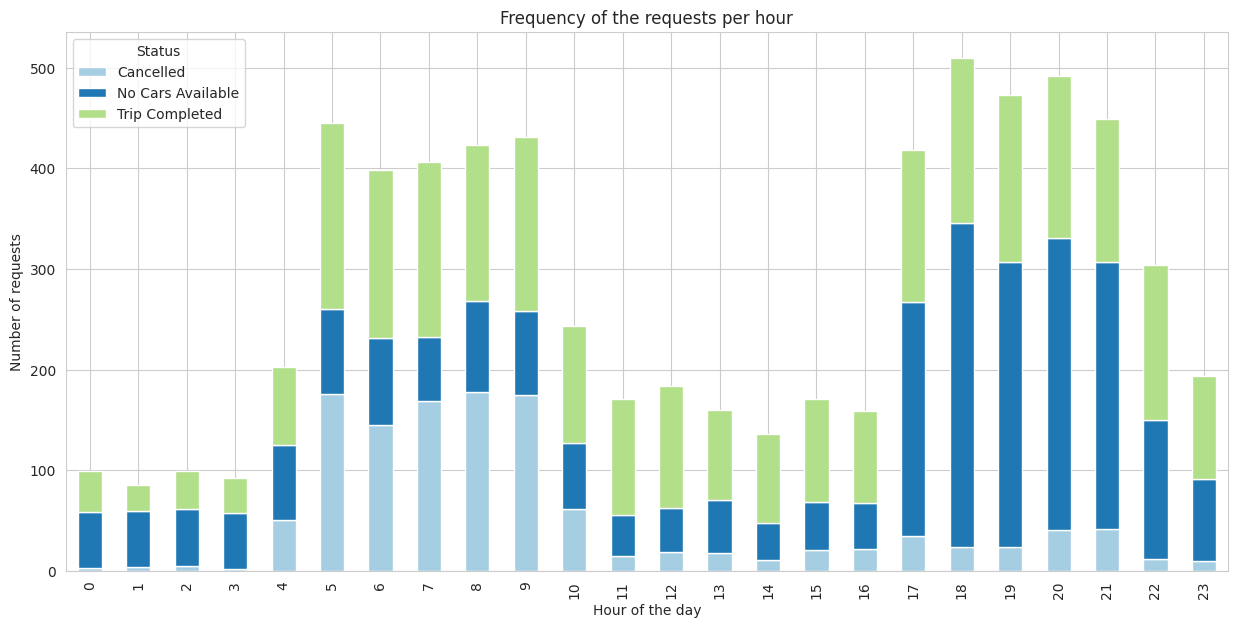

In [17]:
# Number of requests whose status is completed/ No cars available/ Cancelled with respect to the hour
custom_palette = sns.color_palette('Paired')
df.groupby(['request hour', 'Status']).size().unstack().plot(kind = 'bar', stacked = True, figsize = (15,7), color = custom_palette)
plt.xlabel('Hour of the day')
plt.ylabel('Number of requests')
plt.title('Frequency of the requests per hour')

---
* 12AM - 4AM -> No cars available rate is high (demand supply issue)
* 5AM - 10AM -> The cancelled requests are more (driver / customer), the number of requests are high
* 11AM - 4PM -> The numbers seems good
* 5PM - 11PM -> No cars available rate is high (demand supply issue)
---

Text(0.5, 1.0, 'Frequency of the requests per times of day')

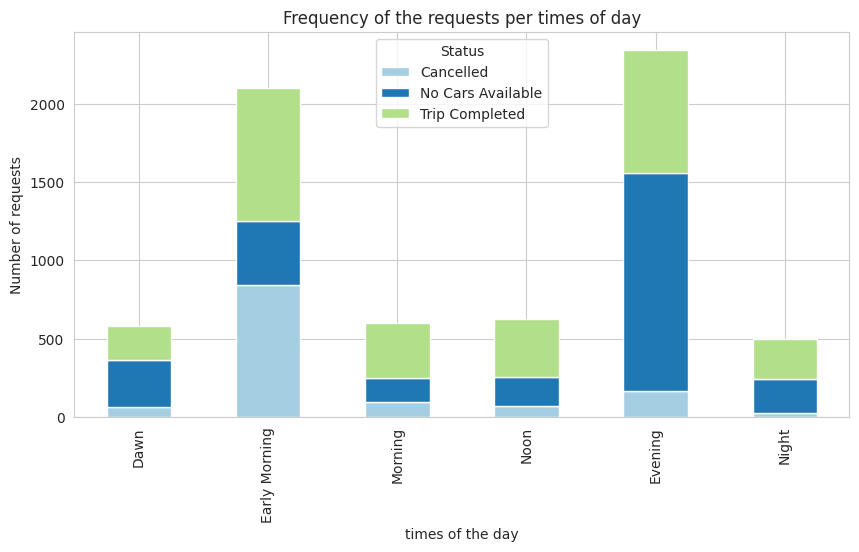

In [18]:
dayorder= ['Dawn', 'Early Morning', 'Morning', 'Noon', 'Evening', 'Night']
df.groupby(['times of day', 'Status']).size().unstack().reindex(dayorder).plot(kind = 'bar', stacked = True, figsize = (10,5), color = custom_palette)
plt.xlabel('times of the day')
plt.ylabel('Number of requests')
plt.title('Frequency of the requests per times of day')

Text(0.5, 1.0, 'Frequency of the pickup points')

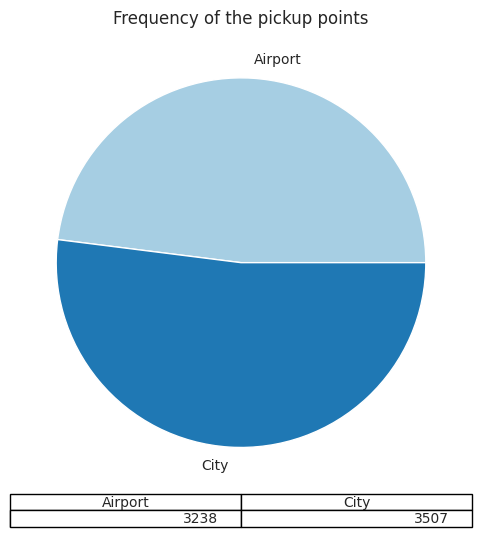

In [19]:
# Number of pick ups from Aiport & from city

df.groupby(['Pickup point']).size().plot(kind = 'pie', stacked = True, figsize=(6, 6), table=True, colors = custom_palette)
plt.title('Frequency of the pickup points')

Text(0.5, 1.0, 'Frequency of the requests per hour with pickup point as Airport')

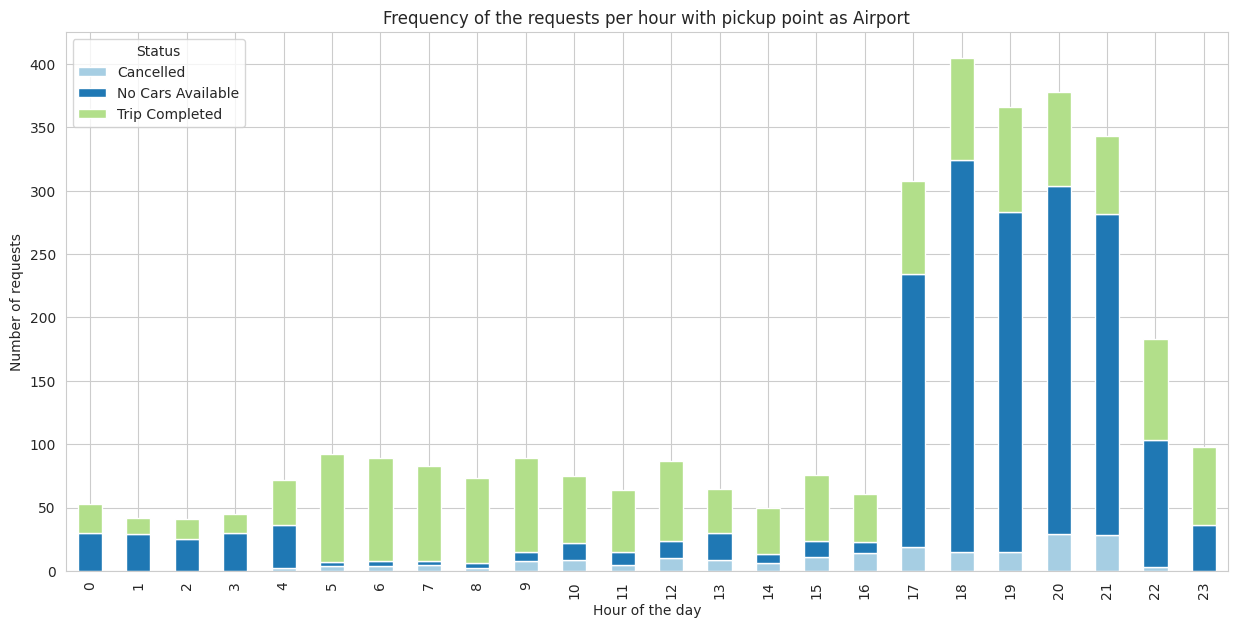

In [20]:
# Number of requests of pick up point Airport 

df[df['Pickup point'] == 'Airport'].groupby(['request hour', 'Status']).size().unstack().plot(kind = 'bar', stacked = True, figsize = (15,7), color = custom_palette)
plt.xlabel('Hour of the day')
plt.ylabel('Number of requests')
plt.title('Frequency of the requests per hour with pickup point as Airport')

---
* b/w 12Am - 4Am & 5Pm - 11Pm there is demand to supply problem, there are lot of requests without no cars availability
---

Text(0.5, 1.0, 'Frequency of the requests per hour with pick up point city')

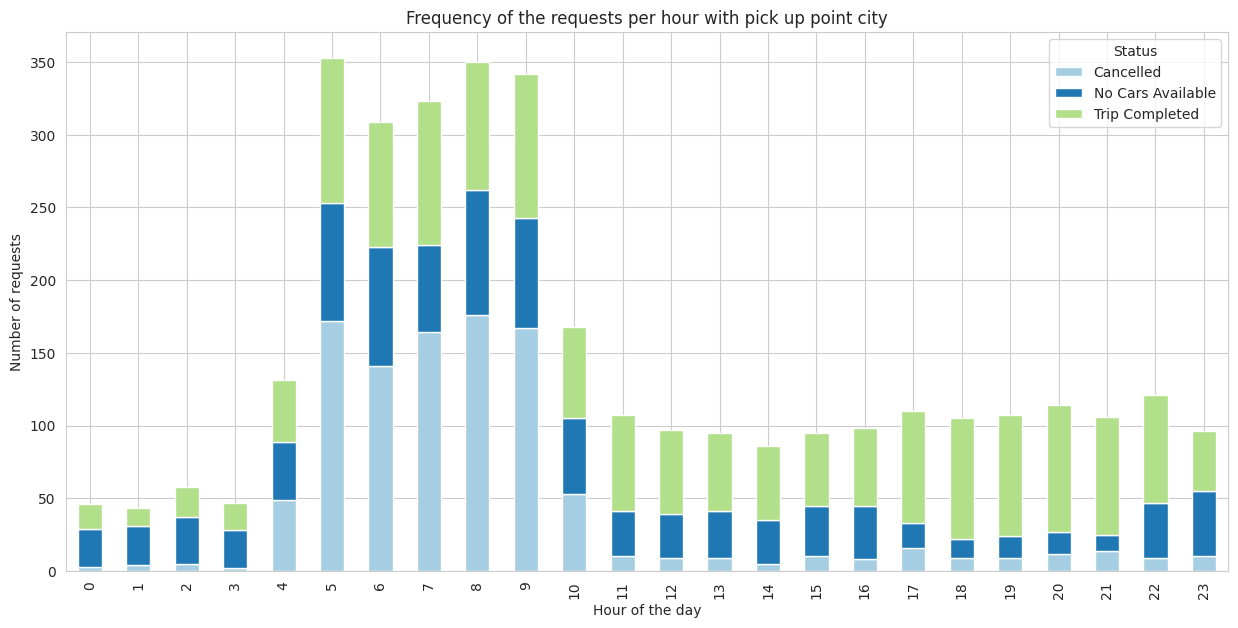

In [21]:
# Number of requests of pick up point city 

df[df['Pickup point'] == 'City'].groupby(['request hour', 'Status']).size().unstack().plot(kind = 'bar', stacked = True, figsize = (15,7), color = custom_palette)
plt.xlabel('Hour of the day')
plt.ylabel('Number of requests')
plt.title('Frequency of the requests per hour with pick up point city')

---
* b/w 12Am - 4Am there is demand to supply problem, there are lot of requests without no cars availability
* b/w 5Am - 10Am there are lot of rides which are getting cancelled either by driver or by customer
---

Text(0.5, 1.0, 'Frequency of requests per times of day')

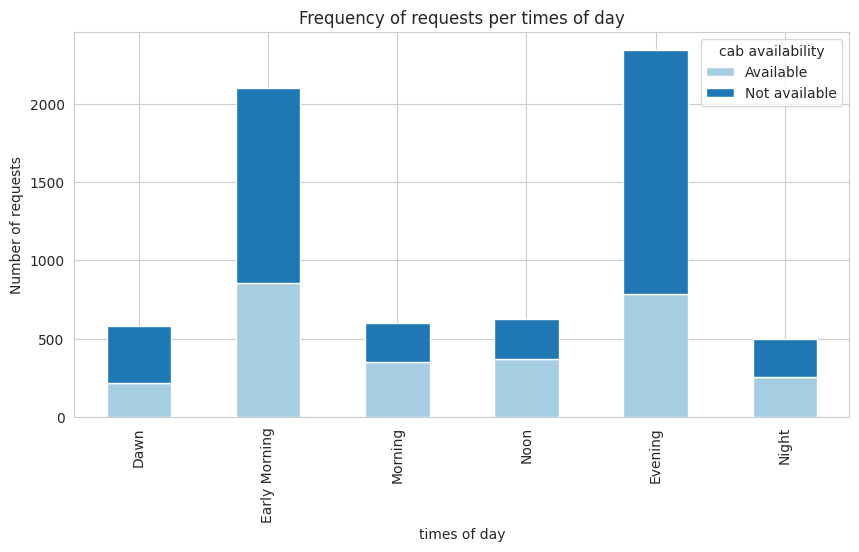

In [22]:
# Times of day where highest gap exists 

df.groupby(['times of day','cab availability']).size().unstack().reindex(dayorder).plot(kind='bar', stacked=True,figsize=(10, 5), color = custom_palette)
plt.ylabel('Number of requests')
plt.title('Frequency of requests per times of day')


---
* There is huge gap at early morning & evening (even the requests are very high compared to other times of day)
* for the other times of day also the distribution is similar (b/w availability) even though there are less number of requests.
---

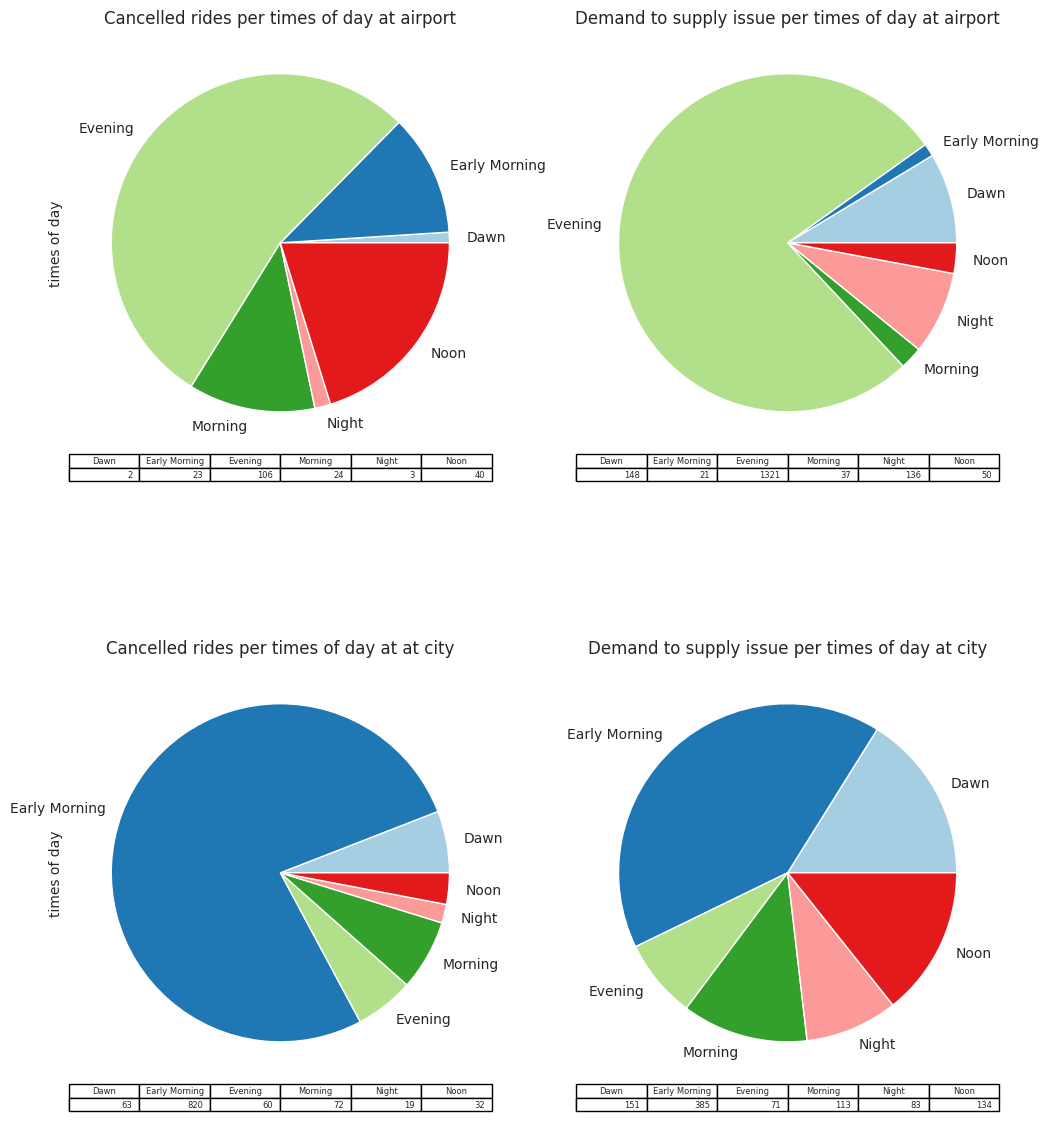

In [43]:
fig = plt.figure(figsize=(9,12))

plt.subplot(2,2,1)
df[(df['Status'] == 'Cancelled') & (df['Pickup point'] == 'Airport')].groupby(['times of day']).size().plot(kind = 'pie', stacked = True, colors = custom_palette, figsize=(12, 15), table=True)
plt.ylabel('times of day')
plt.title('Cancelled rides per times of day at airport')

plt.subplot(2,2,2)
df[(df['Status'] == 'No Cars Available')  & (df['Pickup point'] == 'Airport')].groupby(['times of day']).size().plot(kind = 'pie', stacked = True, colors = custom_palette, figsize=(12, 15), table=True)
plt.title('Demand to supply issue per times of day at airport')

plt.subplot(2,2,3)
df[(df['Status'] == 'Cancelled')  & (df['Pickup point'] == 'City')].groupby(['times of day']).size().plot(kind = 'pie', stacked = True, colors = custom_palette, figsize=(12, 15), table=True)
plt.ylabel('times of day')
plt.title('Cancelled rides per times of day at at city')

plt.subplot(2,2,4)
df[(df['Status'] == 'No Cars Available')  & (df['Pickup point'] == 'City')].groupby(['times of day']).size().plot(kind = 'pie', stacked = True, colors = custom_palette, figsize=(12, 15), table=True)
plt.title('Demand to supply issue per times of day at city')
plt.show()

---
* At city:
    * The cancelled rides are more in the early morning
    * The demand to supply issues are more in early morning & Dawn

* At Airport:
    * The cancelled rides are more in evening, noon
    * The demand to supply issues are more in evening
---

Text(0, 0.5, 'Distribution of Time Slots over cab availability')

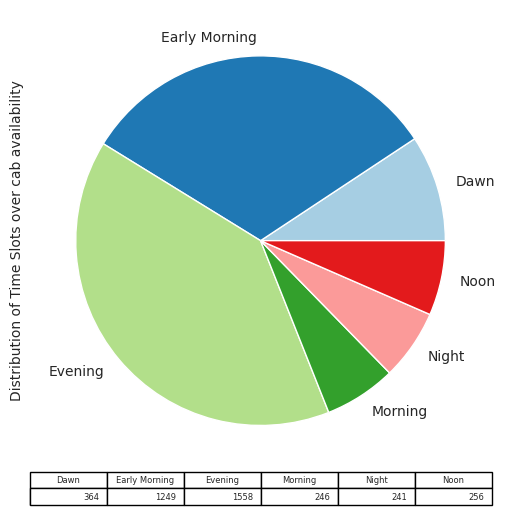

In [49]:
# Distribution of Time Slots over cab availability

df[(df["cab availability"]=="Not available")].groupby(['times of day']).size().plot(kind="pie", stacked=True, figsize=(6, 6), table=True, colors = custom_palette)
plt.ylabel("Distribution of Time Slots over cab availability")

---
* The availability of cab is less is evening & morning
---

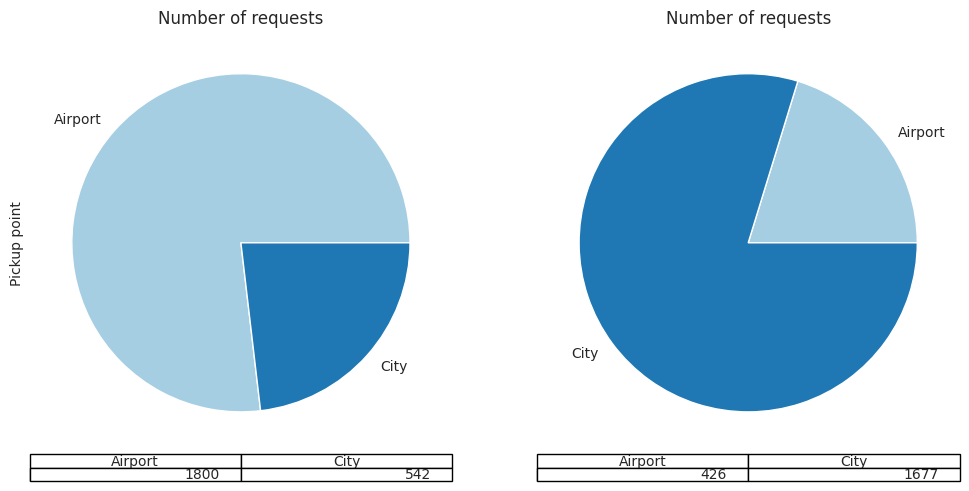

In [52]:
fig = plt.figure(figsize=(9,12))

plt.subplot(2,2,1)
df[(df['times of day'] == 'Evening')].groupby(['Pickup point']).size().plot(kind = 'pie', stacked = True, colors = custom_palette, figsize=(12, 15), table=True)
plt.ylabel('Pickup point')
plt.title('Number of requests')

plt.subplot(2,2,2)
df[(df['times of day'] == 'Early Morning')].groupby(['Pickup point']).size().plot(kind = 'pie', stacked = True, colors = custom_palette, figsize=(12, 15), table=True)
plt.title('Number of requests')
plt.show()

---
* The requests are more from airport at evenings
* The requests are more from city at mornings
---

---
### Reason for Supply-Demand gap -
---

* In the Supply-Demand graph from Airport to City, between 5:00 PM to 9:00 PM there is very high demand for cabs because the supply is very low due to ‘No Cars Available’.

* The ‘No Cars Available’ is due to the fact that in the previous hours fewer people travelled from City – Airport and so fewer cars are available in near Airport. 

* Likewise, in Supply-Demand graph from City – Airport, between 5:00 AM to 9:00 AM, there is very high demand for cabs because the supply is very low due to Ride Cancellations.

* This is because there were fewer trips to Airport that completed in the previous hours, so now the cabs have to come from a long distance (City) to pickup the passenger and then they have to wait for the passenger’s arrival, so the drivers cancel the trip.

---
### Recommendations -
---

* Awarding incentive for waiting time will encourage the drivers to wait at Airport.

* Drivers could be compensated for taking the night shifts hence covering the 00:00 – 5:00 time slot.

* Seeing this analysis trends, few cabs could be placed in Airports proactively.

* Drivers to be rewarded for the Airport rides making up for the loss in time.

* The cab discovery range to be increased for Airport location, so that the search for cabs would be on a wider range.